# Timoshenko Beam Example

This Elastica tutorial explains the basics of setting up and running a simple simulation of rods in Elastica. Elastica simulates Cosserat Rods, which are thin, 1-dimensional rods that undergo all possible modes of deformation. This example considers a Timoshenko beam, which is the deformation of a beam under a constant applied force while accounting for shear deforation and rotational bending. This is a good example of the capabilities of Elastica and Cosserat Rods as it requires accounting for the effects of shear deformation, something that the classical Euler-Bernoulli beam solution does not.

![timoshenko_beam_figure.png](../../assets/timoshenko_beam_figure.png)

## Getting Started
To set up the simulation, the first thing you need to do is import the necessary classes. Here we will only import the classes that we need. The `elastica.modules` classes make it easy to construct different simulation systems. Along with these modules, we need to import a rod class, classes for the boundary conditions, and time-stepping functions. As a note, this method of explicitly importing all classes can be a bit cumbersome. Future releases will simplify this step.

In [14]:
import numpy as np

# Import modules
from elastica.modules import BaseSystemCollection, Constraints, Forcing, Damping

# Import Cosserat Rod Class
from elastica.rod.cosserat_rod import CosseratRod

# Import Damping Class
from elastica.dissipation import AnalyticalLinearDamper

# Import Boundary Condition Classes
from elastica.boundary_conditions import OneEndFixedRod, FreeRod
from elastica.external_forces import EndpointForces

# Import Timestepping Functions
from elastica.timestepper.symplectic_steppers import PositionVerlet
from elastica.timestepper import integrate

Now that we have imported all the necessary classes, we want to create our beam system. We do this by combining all the modules we need to represent the physics that we to include in the simulation. In this case, that is the `BaseSystemCollection`, `Constraint`, `Forcings` and `Damping` because the simulation will consider a rod that is fixed in place on one end, and subject to an applied force on the other end.

In [15]:
class TimoshenkoBeamSimulator(BaseSystemCollection, Constraints, Forcing, Damping):
    pass


timoshenko_sim = TimoshenkoBeamSimulator()

## Creating Rods
With our simulator set up, we can now define the numerical, material, and geometric properties. 

First we define the number of elements in the rod. Next, the material properties are defined for every rod. These are the Young's modulus, the Poisson ratio, the density and the viscous damping coefficient. Finally, the geometry of the rod also needs to be defined by specifying the location of the rod and its orientation, length and radius. 

All of the values defined here are done in SI units, though this is not strictly necessary. You can rescale properties however you want, as long as you use consistent units throughout the simulation. See [here](https://info.simuleon.com/blog/units-in-abaqus) for an example of consistent units.

In order to make the difference between a shearable and unshearable rod more clear, we are using a Poisson ratio of 99. This is an unphysical value, as Poisson ratios can not exceed 0.5, however, it is used here for demonstration purposes. 

In [16]:
# setting up test params
n_elem = 100

density = 1000
nu = 1e-4
E = 1e6
# For shear modulus of 1e4, nu is 99!
poisson_ratio = 99
shear_modulus = E / (poisson_ratio + 1.0)

start = np.zeros((3,))
direction = np.array([0.0, 0.0, 1.0])
normal = np.array([0.0, 1.0, 0.0])
base_length = 3.0
base_radius = 0.25
base_area = np.pi * base_radius ** 2

With all of the rod's parameters set, we can now create a rod with the specificed properties and add the rod to the simulator system. **Important:** Make sure that any rods you create get added to the simulator system (`timoshenko_sim`), otherwise they will not be included in your simulation. 

In [17]:
shearable_rod = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus=E,
    shear_modulus=shear_modulus,
)

timoshenko_sim.append(shearable_rod)

## Adding Damping
With the rod added to the simulator, we can add damping to the rod. We do this using the `.dampen()` option and the `AnalyticalLinearDamper`. We are modifying `timoshenko_sim` simulator to `dampen` the `shearable_rod` object using `AnalyticalLinearDamper` type of dissipation (damping) model.

We also need to define `damping_constant` and simulation `time_step` and pass in `.using()` method.

In [18]:

dl = base_length / n_elem
dt = 0.01 * dl
timoshenko_sim.dampen(shearable_rod).using(
    AnalyticalLinearDamper,
    damping_constant=nu,
    time_step=dt,
)

## Adding Boundary Conditions
With the rod added to the system, we need to apply boundary conditions. The first condition we will apply is fixing the location of one end of the rod. We do this using the `.constrain()` option and the `OneEndFixedRod` boundary condition. We are modifying the `timoshenko_sim` simulator to `constrain` the `shearable_rod` object using the `OneEndFixedRod` type of constraint. 

We also need to define which node of the rod is being constrained. We do this by passing the index of the nodes that we want to constain to `constrained_position_idx`. Here we are fixing the first node in the rod. In order to keep the rod from rotating around the fixed node, we also need to constrain an element between two nodes. This fixes the orientation of the rod. We do this by passing the index of the element that we want to fix to `constrained_director_idx`. Like with the position, we are fixing the first element of the rod. Together, this contrains the position and orientation of the rod at the origin. 

In [19]:
timoshenko_sim.constrain(shearable_rod).using(
    OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
)
print("One end of the rod is now fixed in place")

One end of the rod is now fixed in place


The next boundary condition that we want to apply is the endpoint force. Similarly to how we constrained one of the points, we want the `timoshenko_sim` simulator to `add_forcing_to` the `shearable_rod` object using the `EndpointForces` type of forcing. This `EndpointForces` applies forces to both ends of the rod. We want to apply a negative force in the $d_1$ direction, but only at the end of the rod. We do this by specifying the force vector to be applied at each end as `origin_force` and `end_force`. We also want to ramp up the force over time, so we make the force take some `ramp_up_time` to reach its steady-state value. This helps avoid numerical errors due to discontinuities in the applied force. 

In [20]:
origin_force = np.array([0.0, 0.0, 0.0])
end_force = np.array([-10.0, 0.0, 0.0])
ramp_up_time = 5.0

timoshenko_sim.add_forcing_to(shearable_rod).using(
    EndpointForces, origin_force, end_force, ramp_up_time=ramp_up_time
)
print("Forces added to the rod")

Forces added to the rod


## Add Unshearable Rod

Along with the shearable rod, we also want to add an unshearable rod to be able to compare the difference between the two. We do this the same way we did for the first rod, however, because this rod is unsherable, we need to change the Poisson ratio to make the rod unsherable. For a truely unsheraable rod, you would need a Poisson ratio of -1.0, however, this causes the system to be numerically unstable, so instead we make the system nearly unshearable by using a Poisson ratio of -0.85. 

In [21]:
# Start into the plane
unshearable_start = np.array([0.0, -1.0, 0.0])
unshearable_rod = CosseratRod.straight_rod(
    n_elem,
    unshearable_start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus=E,
    # Unshearable rod needs G -> inf, which is achievable with a poisson ratio of -1.0
    shear_modulus=E / (-0.85 + 1.0),
)

timoshenko_sim.append(unshearable_rod)

timoshenko_sim.dampen(unshearable_rod).using(
    AnalyticalLinearDamper,
    damping_constant=nu,
    time_step=dt,
)

timoshenko_sim.constrain(unshearable_rod).using(
    OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
)

timoshenko_sim.add_forcing_to(unshearable_rod).using(
    EndpointForces, origin_force, end_force, ramp_up_time=ramp_up_time
)
print("Unshearable rod set up")

Unshearable rod set up


## System Finalization

We have now added all the necessary rods and boundary conditions to our system. The last thing we need to do is finalize the system. This goes through the system, rearranges things, and precomputes useful quantities to prepare the system for simulation. 

As a note, if you make any changes to the rod after calling finalize, you will need to re-setup the system. This requires rerunning all cells above this point. 

In [22]:
timoshenko_sim.finalize()
print("System finalized")

System finalized


## Define Simulation Time

The last thing we need to do deceide how long we want the simulation to run for and what timestepping method to use. Currently, the PositionVerlet algorithim is suggested default method. 

In this example, we are trying to match a steady-state solution by temporally evolving our system to reach equillibrium. As such, there is a tradeoff between letting the simulation run long enough to each the equillibrium and waiting around for the simulation to be done. Here we are running the simulation for 10 seconds, this produces reasonable agreement with the analytical solution without taking to long to finish. If you run the simulation for longer, you will get better agreement with the analytical solution. 

In [23]:
final_time = 10.0
total_steps = int(final_time / dt)
print("Total steps to take", total_steps)

timestepper = PositionVerlet()

Total steps to take 33333


## Run Simulation
We are now ready to perform the simulation. To run the simulation, we `integrate` the `timoshenko_sim` system using the `timestepper` method until `final_time` by taking `total_steps`. As currently setup, the beam simulation takes about 1 minute to run. 

In [11]:
integrate(timestepper, timoshenko_sim, final_time, total_steps)

  0%|          | 0/33333 [00:00<?, ?it/s]

100%|██████████| 33333/33333 [00:06<00:00, 5115.24it/s]

Final time of simulation is :  10.00000000000566


10.00000000000566

## Post Processing Results
Now that we have finished the simulation, we want to post-process the results. We will do this by comparing the solutions for the shearable and unshearable beams with the analytical Timoshenko and Euler-Bernoulli beam results. 

In [24]:
# Compute beam position for sherable and unsherable beams.
def analytical_result(arg_rod, arg_end_force, shearing=True, n_elem=500):
    base_length = np.sum(arg_rod.rest_lengths)
    arg_s = np.linspace(0.0, base_length, n_elem)
    if type(arg_end_force) is np.ndarray:
        acting_force = arg_end_force[np.nonzero(arg_end_force)]
    else:
        acting_force = arg_end_force
    acting_force = np.abs(acting_force)
    linear_prefactor = -acting_force / arg_rod.shear_matrix[0, 0, 0]
    quadratic_prefactor = (
        -acting_force
        / 2.0
        * np.sum(arg_rod.rest_lengths / arg_rod.bend_matrix[0, 0, 0])
    )
    cubic_prefactor = (acting_force / 6.0) / arg_rod.bend_matrix[0, 0, 0]
    if shearing:
        return (
            arg_s,
            arg_s * linear_prefactor
            + arg_s ** 2 * quadratic_prefactor
            + arg_s ** 3 * cubic_prefactor,
        )
    else:
        return arg_s, arg_s ** 2 * quadratic_prefactor + arg_s ** 3 * cubic_prefactor

Now we want to plot the results. The one thing to point out in this function is how to access the position of the rods. They are located in `rod.position_collection[dim, n_elem]`. In this case, we are plotting the x- and z-dimensions. 

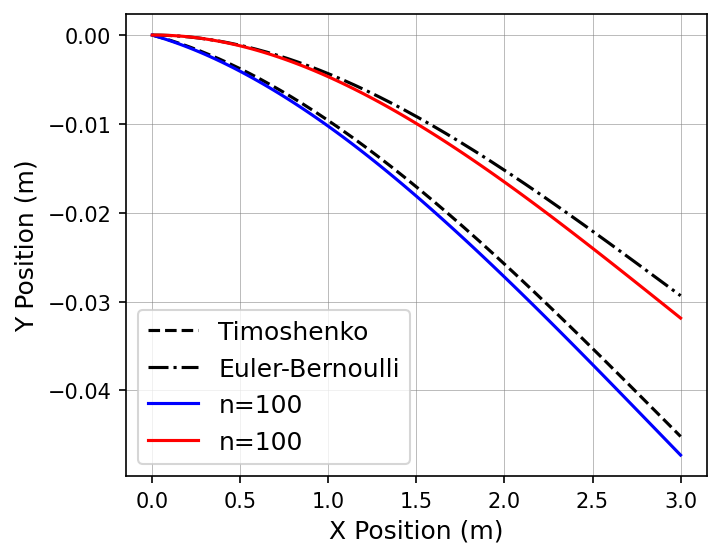

In [13]:
def plot_timoshenko(shearable_rod, unshearable_rod, end_force):
    import matplotlib.pyplot as plt

    analytical_shearable_positon = analytical_result(
        shearable_rod, end_force, shearing=True
    )
    analytical_unshearable_positon = analytical_result(
        unshearable_rod, end_force, shearing=False
    )

    fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
    ax = fig.add_subplot(111)
    ax.grid(which="major", color="grey", linestyle="-", linewidth=0.25)

    ax.plot(
        analytical_shearable_positon[0],
        analytical_shearable_positon[1],
        "k--",
        label="Timoshenko",
    )
    ax.plot(
        analytical_unshearable_positon[0],
        analytical_unshearable_positon[1],
        "k-.",
        label="Euler-Bernoulli",
    )

    ax.plot(
        shearable_rod.position_collection[2, :],
        shearable_rod.position_collection[0, :],
        "b-",
        label="n=" + str(shearable_rod.n_elems),
    )
    ax.plot(
        unshearable_rod.position_collection[2, :],
        unshearable_rod.position_collection[0, :],
        "r-",
        label="n=" + str(unshearable_rod.n_elems),
    )

    ax.legend(prop={"size": 12})
    ax.set_ylabel("Y Position (m)", fontsize=12)
    ax.set_xlabel("X Position (m)", fontsize=12)
    plt.show()


plot_timoshenko(shearable_rod, unshearable_rod, end_force)

For the sake of time, we are stopping this simulation early. This leads to some disagreement between the analytical solution and the Elastica solution as there are still some transient effects in the Elastica solution. Allowing the simulation to run longer will lead to a closer result between the analytical and Elastica solutions. 

## Dynamic Plotting 
To illustrate how the system evolves over time, we can also plot the system in time. To do this, we need to recreate the system, which we now call `BeamSimulator`. It is the same as the previous system so we will just write everything very compactly to save space. We also slightly modify our plotting and integrating functions to allow the output to be plotting during the simulation. 

Since we will be plotting the system over time, we also need to initalize the time at 0.0

In [25]:
time = 0.0


class BeamSimulator(BaseSystemCollection, Constraints, Forcing, Damping):
    pass


dynamic_update_sim = BeamSimulator()

shearable_rod_new = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus=E,
    shear_modulus=shear_modulus,
)
dynamic_update_sim.append(shearable_rod_new)
dynamic_update_sim.dampen(shearable_rod_new).using(
    AnalyticalLinearDamper,
    damping_constant=nu,
    time_step=dt,
)
dynamic_update_sim.constrain(shearable_rod_new).using(
    OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
)
dynamic_update_sim.add_forcing_to(shearable_rod_new).using(
    EndpointForces, origin_force, end_force, ramp_up_time=ramp_up_time
)

unshearable_rod_new = CosseratRod.straight_rod(
    n_elem,
    unshearable_start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus=E,
    # Unshearable rod needs G -> inf, which is achievable with a poisson ratio of -1.0
    shear_modulus=E / (-0.85 + 1.0),
)
dynamic_update_sim.append(unshearable_rod_new)
dynamic_update_sim.dampen(unshearable_rod_new).using(
    AnalyticalLinearDamper,
    damping_constant=nu,
    time_step=dt,
)
dynamic_update_sim.constrain(unshearable_rod_new).using(
    OneEndFixedRod, constrained_position_idx=(0,), constrained_director_idx=(0,)
)
dynamic_update_sim.add_forcing_to(unshearable_rod_new).using(
    EndpointForces, origin_force, end_force, ramp_up_time=ramp_up_time
)

dynamic_update_sim.finalize()


def run_and_update_plot(simulator, dt, start_time, stop_time, ax):
    from elastica.timestepper import extend_stepper_interface
    from elastica.timestepper.symplectic_steppers import PositionVerlet

    timestepper = PositionVerlet()
    do_step, stages_and_updates = extend_stepper_interface(timestepper, simulator)

    n_steps = int((stop_time - start_time) / dt)
    time = start_time
    for i in range(n_steps):
        time = do_step(timestepper, stages_and_updates, simulator, time, dt)
    plot_timoshenko_dynamic(shearable_rod_new, unshearable_rod_new, end_force, time, ax)
    return time


def plot_timoshenko_dynamic(shearable_rod, unshearable_rod, end_force, time, ax):
    import matplotlib.pyplot as plt
    from IPython import display

    analytical_shearable_positon = analytical_result(
        shearable_rod, end_force, shearing=True
    )
    analytical_unshearable_positon = analytical_result(
        unshearable_rod, end_force, shearing=False
    )

    ax.clear()
    ax.grid(which="major", color="grey", linestyle="-", linewidth=0.25)
    ax.plot(
        analytical_shearable_positon[0],
        analytical_shearable_positon[1],
        "k--",
        label="Timoshenko",
    )
    ax.plot(
        analytical_unshearable_positon[0],
        analytical_unshearable_positon[1],
        "k-.",
        label="Euler-Bernoulli",
    )

    ax.plot(
        shearable_rod.position_collection[2, :],
        shearable_rod.position_collection[0, :],
        "b-",
        label="shearable rod",
    )
    ax.plot(
        unshearable_rod.position_collection[2, :],
        unshearable_rod.position_collection[0, :],
        "r-",
        label="unshearable rod",
    )

    ax.legend(prop={"size": 12}, loc="lower left")
    ax.set_ylabel("Y Position (m)", fontsize=12)
    ax.set_xlabel("X Position (m)", fontsize=12)
    ax.set_title("Simulation Time: %0.2f seconds" % time)
    ax.set_xlim([-0.1, 3.1])
    ax.set_ylim([-0.045, 0.002])

Now we can run the simulation for a time interval `evolve_for_time` and have the system be plotted every `update_interval`. If you run the cell multiple times in a row, you will see that the that the system continues to evolve in time, this is because you are continually updating `dynamic_update_sim`. If you want to reset the system back to its original configuration, run the cell above this one. 

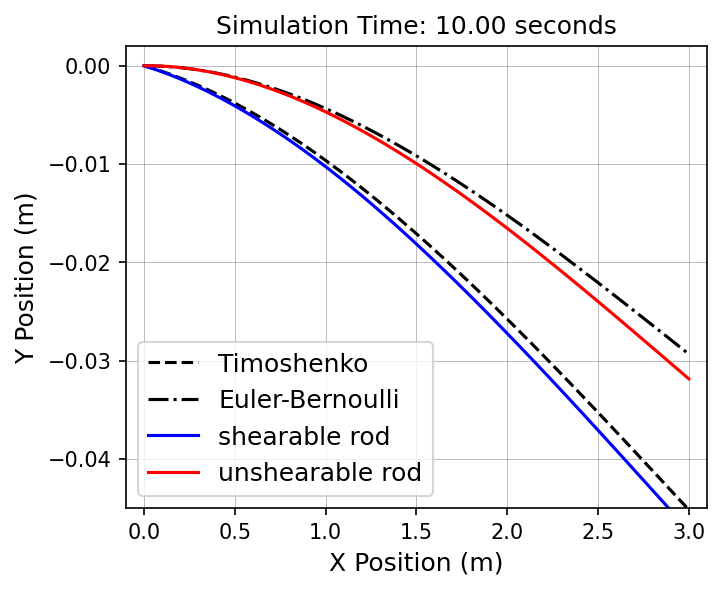

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

evolve_for_time = 10.0
update_interval = 1.0e-1

# update the plot every 1 second
fig = plt.figure(figsize=(5, 4), frameon=True, dpi=150)
ax = fig.add_subplot(111)
first_interval_time = update_interval + time
last_interval_time = time + evolve_for_time
for stop_time in np.arange(
    first_interval_time, last_interval_time + dt, update_interval
):
    time = run_and_update_plot(dynamic_update_sim, dt, time, stop_time, ax)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

### Important note on saving data:
This current method of plotting data during the simulation is helpful for visualizing how the system evolves, but it is computationally inefficient as we are constantly pausing the simulation to plot. It also does not save data for additional post-processing later. A better method for saving data from a simulation is to use call-back functions. There is information on how to use these functions in the [snake tutorial](./2_Slithering_Snake.ipynb)